<a href="https://colab.research.google.com/github/UMassIonTrappers/quantum-computing-labs/blob/main/labs/Lab_07_Quantum_circuits_quantum_adder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 550/650 QC

## Introduction to Quantum Computing

Robert Niffenegger (rniffenegger@umass.edu )

In [59]:
try:
  import qutip
except ImportError:
  print('Install Qutip')
  !pip install --quiet qutip
  '''New library from Qutip https://arxiv.org/pdf/2105.09902v2.pdf '''
  !pip install --quiet qutip-qip

try:
  import qiskit
except ImportError:
  print('Install Qiskit')
  !pip install --quiet qiskit
  !pip install --quiet qiskit[visualization]
  # !pip install --quiet git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

try:
  from qiskit_aer import QasmSimulator
  print('Qiskit Aer imported');
except ImportError:
  print('Install Qiskit-Aer')
  !pip install --quiet qiskit-aer

!pip install --quiet qiskit_ibm_provider[visualization]
!pip install --quiet qiskit-ibm-runtime

!pip install --quiet graphviz

Qiskit Aer imported


### Initialize

In [61]:
%matplotlib inline
from IPython.display import display, Math
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos

#Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

#QuTiP imports
import qutip as qt
from qutip import *

#QUTIP QIP
from qutip.qip import *
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import Gate
from qutip_qip.qasm import circuit_to_qasm_str


#Qisket imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city
from qiskit_aer import QasmSimulator

from qiskit.quantum_info import Statevector
'''
In Jupyter Notebooks we can display this nicely using Latex.
'''
from qiskit.visualization import array_to_latex

from scipy import constants

# LAB 7 - Advanced Quantum Circuits and the Quantum Adder

For this lab we will be following Thomas Wong's textbook.

It is available for free as a pdf here:
* http://www.thomaswong.net/
* http://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e2p.pdf

We will focus on 4.5 and 5.2.4 which cover the Quantum Adder

First please review the classical portion of the book on classical digital adders  ( 1.3 Adders )

That section goes over how to construct a digital binary adder with logical gates.


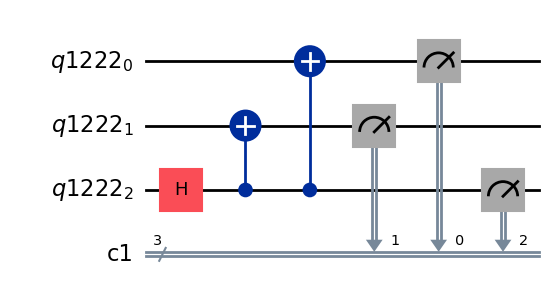

In [62]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(3)
creg_c = ClassicalRegister(3)
circuit = QuantumCircuit(qreg_q, creg_c)

# circuit = QuantumCircuit(3, 3)
circuit.h(qreg_q[2])
circuit.cx(qreg_q[2], qreg_q[1])
circuit.cx(qreg_q[2], qreg_q[0])
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c[1])
circuit.measure(qreg_q[2], creg_c[2])


circuit.draw('mpl')

# Advanced Quantum Circuits


https://qiskit.org/documentation/tutorials/circuits_advanced/01_advanced_circuits.html

#Define a custom quantum gate

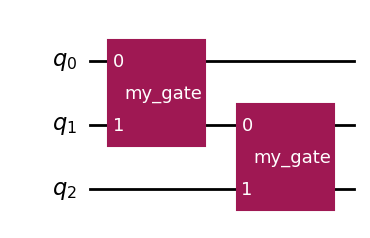

In [63]:
from qiskit.circuit import Gate

'''
Custom gate
'''
my_gate = Gate(name='my_gate', num_qubits=2, params=[])

qr = QuantumRegister(3, 'q')

circ = QuantumCircuit(qr)
circ.append(my_gate, [qr[0], qr[1]])
circ.append(my_gate, [qr[1], qr[2]])

circ.draw('mpl')

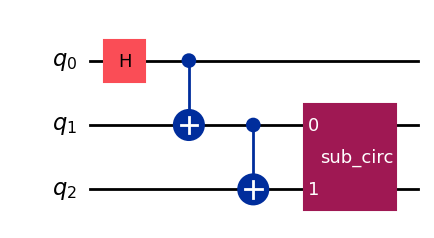

In [64]:
# Build a sub-circuit
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')
sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.id(sub_q[1])
sub_circ.u(1, 2, -2, sub_q[0])

# Convert to a gate and stick it into an arbitrary place in the bigger circuit
sub_inst = sub_circ.to_instruction()

qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.cx(qr[1], qr[2])
circ.append(sub_inst, [qr[1], qr[2]])

circ.draw('mpl')

# QASM

We have used QASM to convert from Qutip gates to Qiskit gates before

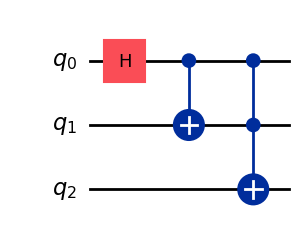

In [65]:
'''
QUTIP circuit
'''
qc = QubitCircuit(3)
qc.add_gate("SNOT", 0)
qc.add_gate("CNOT", 1, 0)
qc.add_gate("TOFFOLI", targets=2, controls=[0,1])

#Convert to QASM
qasmstr = circuit_to_qasm_str(qc)

#Draw using Qiskit
qkqc = QuantumCircuit.from_qasm_str(qasmstr)#Import to Qisket
qkqc.draw('mpl')# Draw with QISKET

In [66]:
print(qasmstr)

// QASM 2.0 file generated by QuTiP

OPENQASM 2.0;
include "qelib1.inc";

qreg q[3];

h q[0];
cx q[0],q[1];
ccx q[0],q[1],q[2];



## Define qiskit gates using QASM string

Note how TRIPLE quotes are used to define a multi-line string

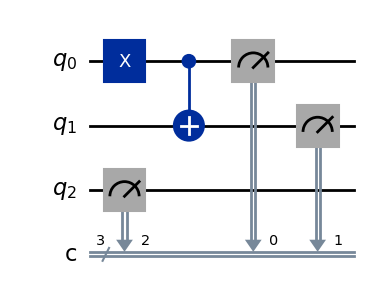

In [67]:
qasmstr = """
OPENQASM 2.0;
// Define the Pauli X gate.
gate x a
{
U(pi,0,pi) a;
}
qreg q[3];
creg c[3];
x q[0];
CX q[0], q[1];
measure q -> c;
"""

#Import to Qisket
qkqc = QuantumCircuit.from_qasm_str(qasmstr)
qkqc.draw('mpl')

#Quantum Sum

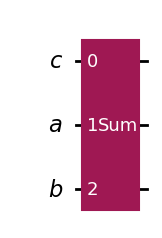

In [68]:
qasmstr = """
OPENQASM 2.0;
// Include standard gates from IBM Quantum Experience.
include "qelib1.inc";
// Define the quantum sum gate.
gate sum cin, a, b
{
cx a, b;
cx cin, b;
}
// Declare the quantum registers.
qreg c[1];
qreg a[1];
qreg b[1];
// Add the numbers so that |a>|b> becomes |a>|a+b>.
sum c[0], a[0], b[0];
"""

#Import to Qisket
qkqc = QuantumCircuit.from_qasm_str(qasmstr)
qkqc.draw('mpl')

## Decompose circuit into bare CNOT gates then draw

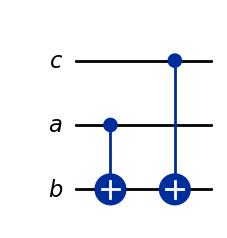

In [69]:
decomposed_circ = qkqc.decompose()
decomposed_circ.draw('mpl')

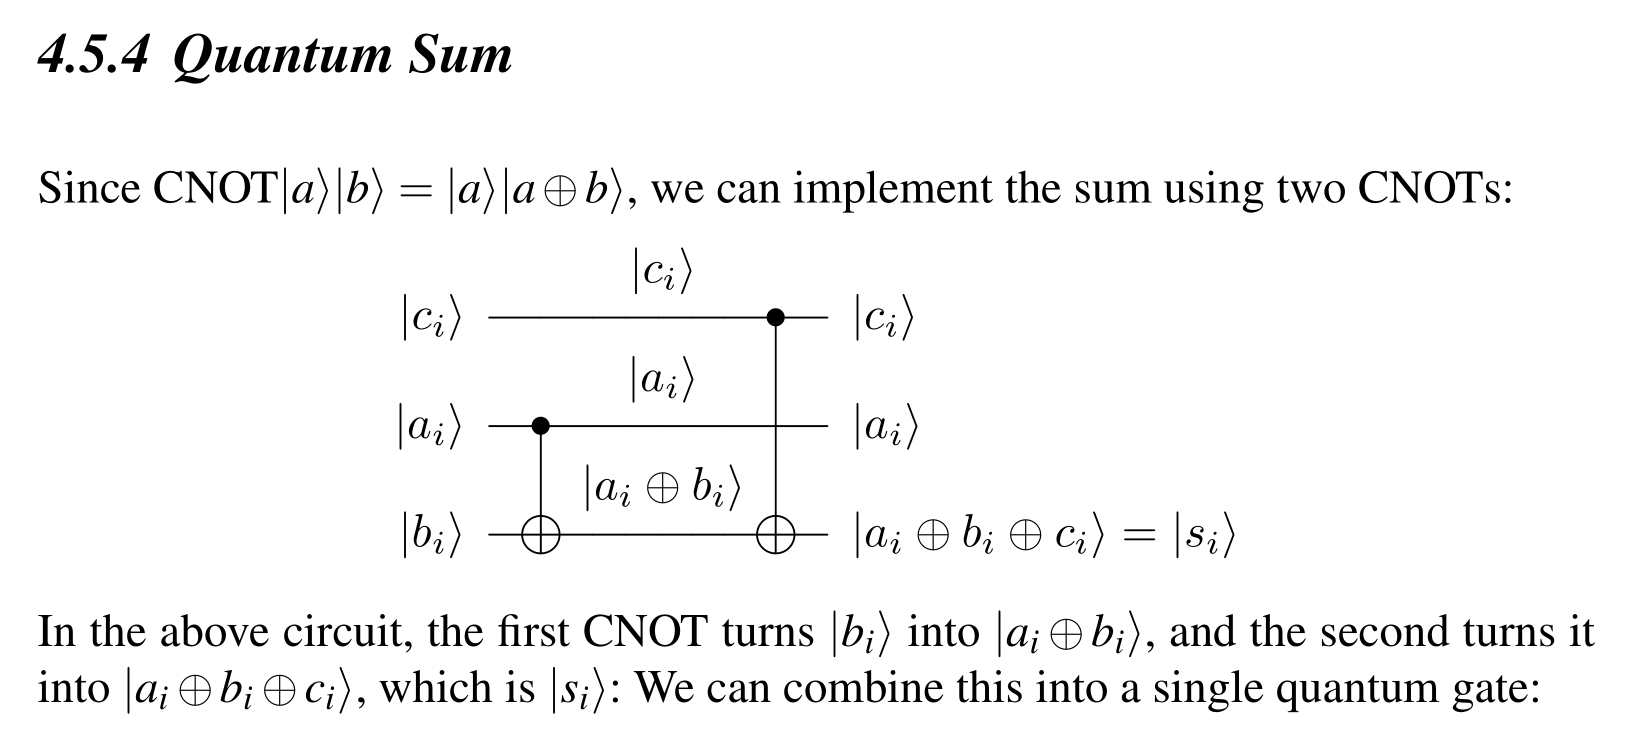

# Quantum Sum with Carry

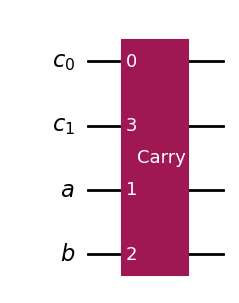

In [70]:
qasmstr = """
OPENQASM 2.0;
// Include standard gates from IBM Quantum Experience.
include "qelib1.inc";
// Define the quantum carry gate.
gate carry cin, a, b, cout
{
ccx a, b, cout;
cx a, b;
ccx cin, b, cout;
}
// Declare the quantum registers.
qreg c[2];
qreg a[1];
qreg b[1];
// Add the numbers so that |a>|b> becomes |a>|a+b>.
carry c[0], a[0], b[0], c[1];
"""

#Import to Qisket
qkqc = QuantumCircuit.from_qasm_str(qasmstr)
qkqc.draw('mpl')

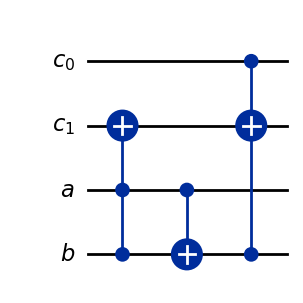

In [71]:
decomposed_circ = qkqc.decompose()
decomposed_circ.draw('mpl')

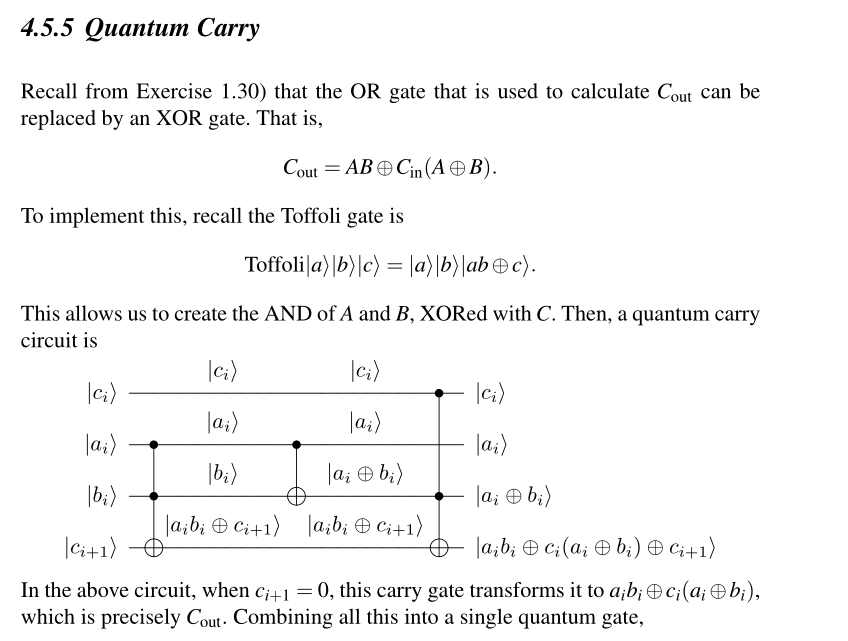

# Full Quantum Ripple Adder

Let's add the numbers a = 14 and b = 11


In [72]:
'''
Remind ourselves of useful python functions for conversion
'''

a = 14
binarystring = format(a,"b")
print(binarystring)
print(int(binarystring,2))

b = 11
binarystring = format(b,"b")
print(binarystring)
print(int(binarystring,2))


1110
14
1011
11


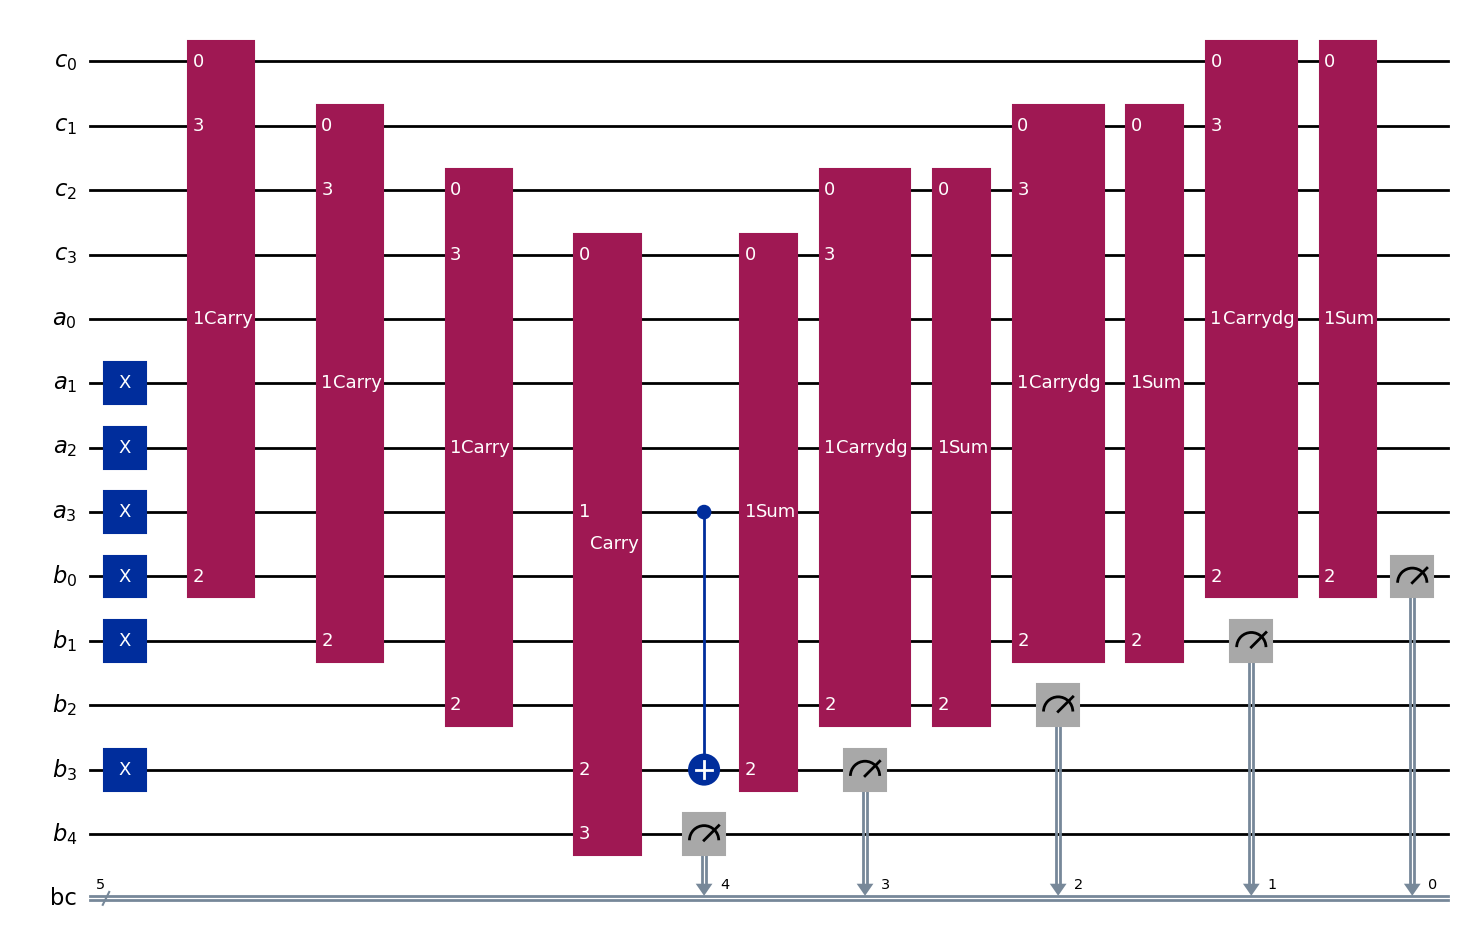

In [73]:
qasmstr = """
OPENQASM 2.0;
// Include standard gates from IBM Quantum Experience.
include "qelib1.inc";
// Define the quantum sum gate.
gate sum cin, a, b
{
cx a, b;
cx cin, b;
}
// Define the quantum carry gate.
gate carry cin, a, b, cout
{
ccx a, b, cout;
cx a, b;
ccx cin, b, cout;
}
// Define the inverse of the quantum carry gate.
gate carrydg cin, a, b, cout
{
ccx cin, b, cout;
cx a, b;
ccx a, b, cout;
}
// Declare the quantum registers.
qreg c[4];
qreg a[4];
qreg b[5];
// Declare the classical registers.
creg bc[5];
//
// Set the input states by applying X gates.
//
x a[1];
x a[2];
x a[3];
// a = 1110
x b[0];
x b[1];
x b[3];
// b = 1011
// Add the numbers so that |a>|b> becomes |a>|a+b>.
carry c[0], a[0], b[0], c[1];
carry c[1], a[1], b[1], c[2];
carry c[2], a[2], b[2], c[3];
carry c[3], a[3], b[3], b[4];
cx a[3], b[3];
sum c[3], a[3], b[3];
carrydg c[2], a[2], b[2], c[3];
sum c[2], a[2], b[2];
carrydg c[1], a[1], b[1], c[2];
sum c[1], a[1], b[1];
carrydg c[0], a[0], b[0], c[1];
sum c[0], a[0], b[0];
// Measure the sum and put it in the classical register.
measure b -> bc;
"""

#Import to Qisket
qc = QuantumCircuit.from_qasm_str(qasmstr)
qc.draw('mpl')


Decompose the circuit one layer into the Toffoli (Control-Control-Not gates) and the CNOT gates.


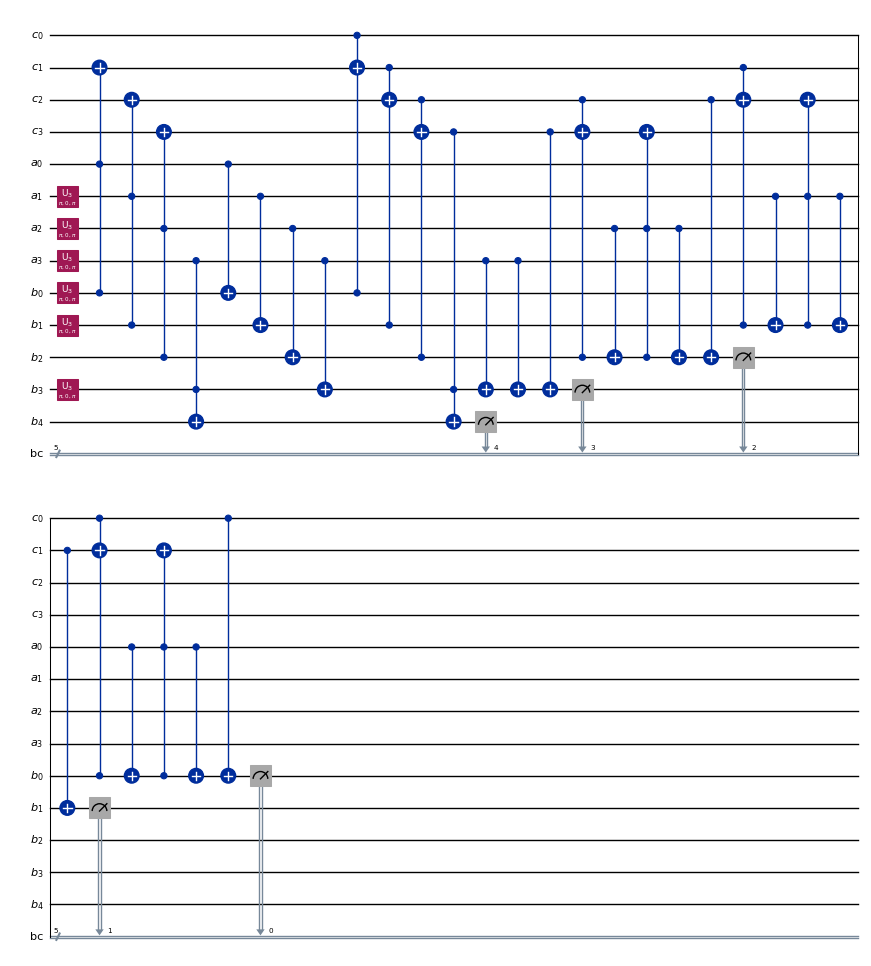

In [74]:
decomposed_circ = qc.decompose() # Does not modify original circuit
decomposed_circ.draw('mpl', scale = 0.5)

Decompose another layer, breaking the Toffoli gates into CNOT gates for running on a superconducting system.

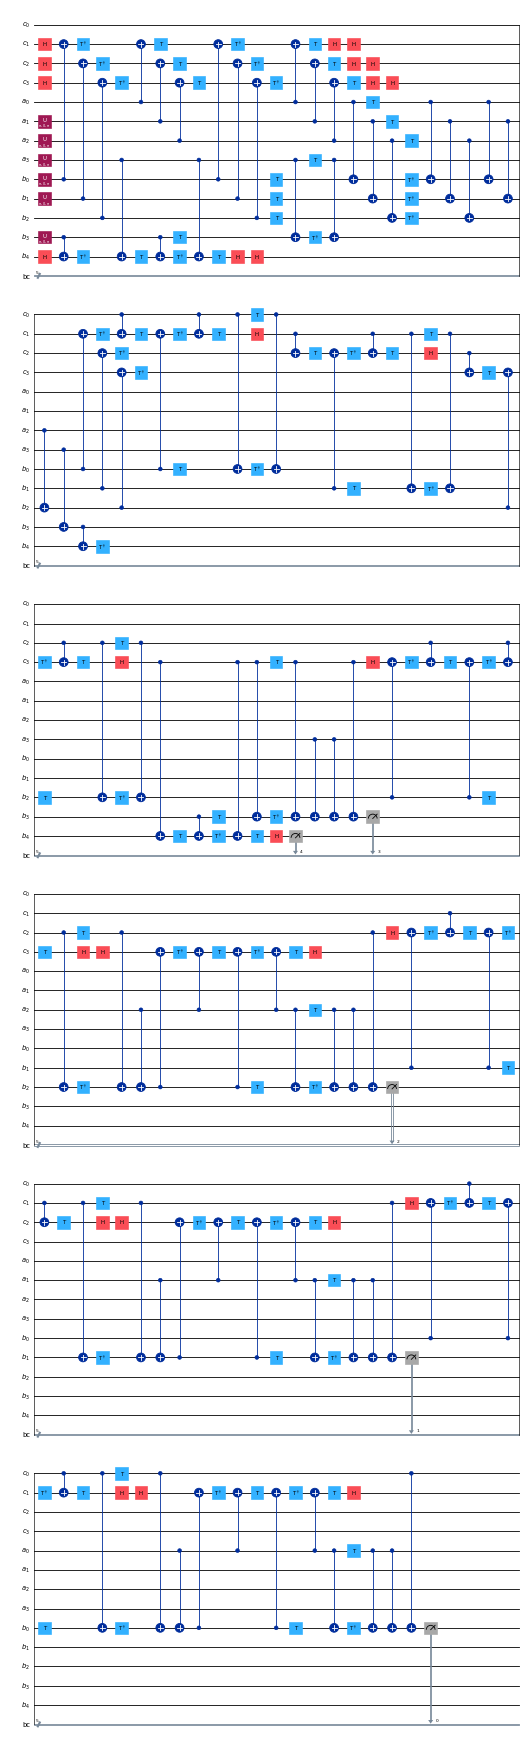

In [16]:
decomposed_circ_full = decomposed_circ.decompose()
decomposed_circ_full.draw('mpl' , scale = 0.3)

In [75]:
'''
Calculate the depth of the quantum circuit
'''
decomposed_circ_full.depth()

119

More details on transpiling here: https://qiskit.org/documentation/apidoc/transpiler.html

https://arxiv.org/abs/2102.01682


## Over 100 gates just to add two 5 bit numbers!


In [76]:
qc = QuantumCircuit.from_qasm_str(qasmstr)
qc.save_statevector() #just simulate the statevector

decomposed_circ = qc.decompose() # Does not modify original circuit

QasmSim = QasmSimulator() #Set simulator to evolve state

job = QasmSim.run(decomposed_circ, shots=1) #only need 1 shot for statevector 'measurement'

{'11001': 1}


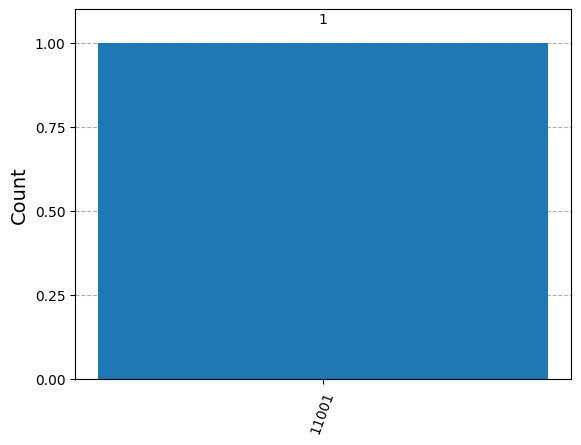

In [77]:
'''Plot results'''
counts = job.result().get_counts()
print(counts)
plot_histogram(counts)

In [78]:
binarystring = format(25,"b")
print(binarystring)
print(int(binarystring,2))

11001
25


### Quantum computing* success!

14 + 11 = 25

(simulated statevector*)

# Running on the cloud

Next we will sign up to access IBM's quantum computers on the cloud.

It is free to register and doesn't take too long.

https://quantum-computing.ibm.com/login


Once you've registered you can use your unique API token to access their hardware and simulators via the cloud.


In [79]:
# Create circuit to test transpiler on
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import GroverOperator, Diagonal

# Use Statevector object to calculate the ideal output
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, SamplerV2 as Sampler

In [22]:
token = "INSERT YOUR TOKEN HERE"

In [80]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True,
  set_as_default=True
)

In [40]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
 
# Create empty circuit
example_circuit = QuantumCircuit(2)
example_circuit.measure_all()
 
# You'll need to specify the credentials when initializing QiskitRuntimeService, if they were not previously saved.
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
 
sampler = Sampler(backend)
job = sampler.run([example_circuit])
print(f"job id: {job.job_id()}")
result = job.result()
print(result)

job id: czhaf8x7m0r0008w438g
PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-03-25 12:55:03', stop='2025-03-25 12:55:05', size=4096>)])}, 'version': 2})


# Find a Quantum Computer to run circuit on

In [48]:
# You'll need to specify the credentials when initializing QiskitRuntimeService, if they were not previously saved.
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend)

<IBMBackend('ibm_sherbrooke')>


In [ ]:
# backend = service.backend('ibm_sherbrooke') # You can also specify which QPU to use...but the wait could be hours...
# backend = service.backend('ibm_brisbane')


In [83]:
print(backend)

<IBMBackend('ibm_sherbrooke')>


# Can we run the circuit directly on the quantum computer???

In [127]:
qc = QuantumCircuit.from_qasm_str(qasmstr)

sampler = Sampler(backend)
job = sampler.run([qc])
print(f"job id: {job.job_id()}")
result = job.result()
print(result)

IBMInputValueError: 'The instruction carry on qubits (0, 4, 8, 1) is not supported by the target system. Circuits that do not match the target hardware definition are no longer supported after March 4, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/guides/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/guides/primitives-examples) to see this coupled with operator transformations.'

# No. The quantum circuit doesn't run directly without transpiling to hardware...

In [92]:
# List two-qubit gates to count in circuits as proxy for depth
twoQ_gates = set(['ecr', 'cz', 'cx'])
for gate in backend.basis_gates:
    if gate in twoQ_gates:
        twoQ_gate = gate

In [93]:
qc = QuantumCircuit.from_qasm_str(qasmstr) #create circuit from QASM
transpiled_circuit = transpile(qc, backend)
optimization_level = 0
print(f"Two-qubit gates: ", transpiled_circuit.count_ops()[twoQ_gate])

Two-qubit gates:  152


In [108]:
qc = QuantumCircuit.from_qasm_str(qasmstr) #create circuit from QASM

# initial_layout = [103,104,105,106,107,108,112,126,125,124,123,122,111] #you can specify the qubits to use
initial_layout = []

optimization_level = 0 # The level of optimization for the transpiler 

pass_manager = generate_preset_pass_manager(
    optimization_level, backend=backend, seed_transpiler=0, initial_layout=initial_layout
)

transpiled_circ = pass_manager.run(qc)
 
print(f"Two-qubit gates (optimization_level={optimization_level}): ", transpiled_circ.count_ops()[twoQ_gate])

# transpiled_circ.draw("mpl", idle_wires=False, fold=40, scale=0.5)

Two-qubit gates (optimization_level=0):  313


In [29]:
# from graphviz import Graph 

# from qiskit.visualization import plot_error_map
 
# plot_error_map(backend, figsize=(30, 24))

## Now that we've transpiled we can run on quantum computer

In [ ]:
# Define Sampler
sampler = Sampler(mode=backend)
 
# Run calculation
job = sampler.run([transpiled_circuit], shots=1000)
counts = job.result()[0].data.bc.get_counts()

{'01001': 28, '11000': 40, '10110': 39, '00001': 31, '10100': 27, '11010': 28, '10101': 27, '00111': 27, '01011': 31, '01000': 33, '01010': 34, '11011': 29, '11110': 30, '01111': 37, '11001': 30, '00101': 37, '01101': 29, '01100': 40, '00110': 40, '00011': 25, '11101': 27, '11100': 32, '10011': 22, '01110': 30, '10001': 33, '00000': 33, '10010': 28, '00100': 33, '00010': 36, '11111': 31, '10111': 23, '10000': 30}


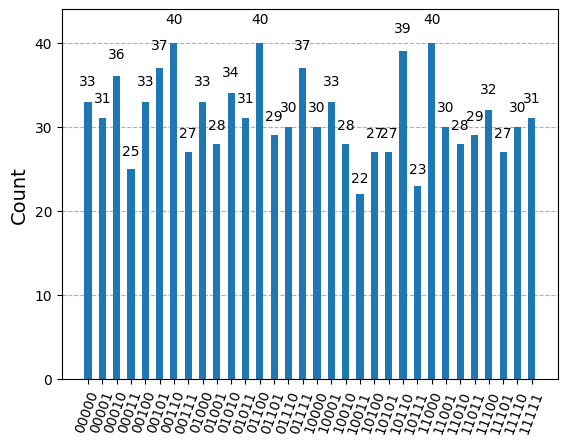

In [166]:
'''Plot results'''
print(count)
plot_histogram(count)

### Hmm... not a clear signal showing our expected solution...

Let's try optimizing the circuit to run with higher fidelity.
We'll set the 'optimization level to 3' during the transpiling and see if that helps.

In [112]:
qc = QuantumCircuit.from_qasm_str(qasmstr)

# Find the correct two-qubit gate
twoQ_gates = set(['ecr', 'cz', 'cx'])
for gate in backend.basis_gates:
    if gate in twoQ_gates:
        twoQ_gate = gate

circuits = []
for optimization_level in [0, 3]:
    pm = generate_preset_pass_manager(optimization_level, backend=backend, seed_transpiler=0)
    t_qc = pm.run(qc)
    print(f"Two-qubit gates (optimization_level={optimization_level}): ", t_qc.count_ops()[twoQ_gate])
    circuits.append(t_qc)

Two-qubit gates (optimization_level=0):  313
Two-qubit gates (optimization_level=3):  153


Nice! Transpiling with a higher optimization level (3) reduced the number of two qubit gates by half! The error should be reduced significantly!

In [168]:
with Batch(backend=backend):
    sampler = Sampler()
    job = sampler.run(
        [(circuit) for circuit in circuits],  # sample all three circuits
        shots=1000
    )
    result = job.result()

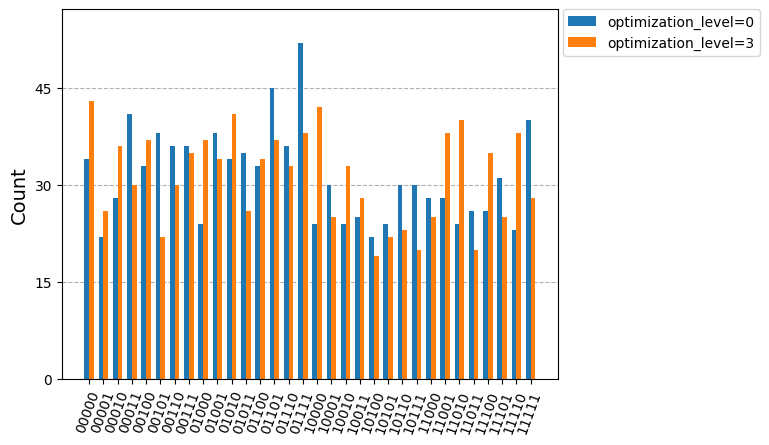

In [169]:
'''Plot results'''
plot_histogram(
    [result[0].data.bc.get_counts(),
     result[1].data.bc.get_counts()],
    bar_labels=False,
    legend=[
        "optimization_level=0",
        "optimization_level=3"#,
    ],
)

Well that did 'something'... but the expected answer (11001) is still not the most likely result...and is well within the noise...

In [115]:
qc = QuantumCircuit.from_qasm_str(qasmstr)
decomposed_circ = qc.decompose() # Does not modify original circuit

We can look at all the available cloud backends we could try.


https://quantum.ibm.com/services/resources


https://pypi.org/project/qiskit-ibm-runtime/



However, they all have long queues....

In [170]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

# Display all backends you have access.
print(service.backends())

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]


# Fake qubits

Instead of waiting for a 'real' quantum computer to open up... we can simulate a fake version of a quantum computer into the simulator and use its noise characteristics to simulate the circuit.

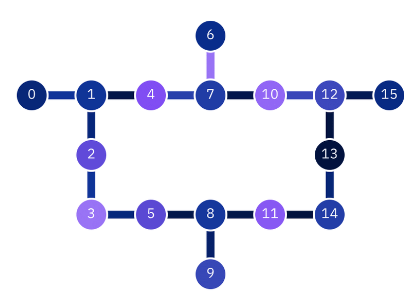

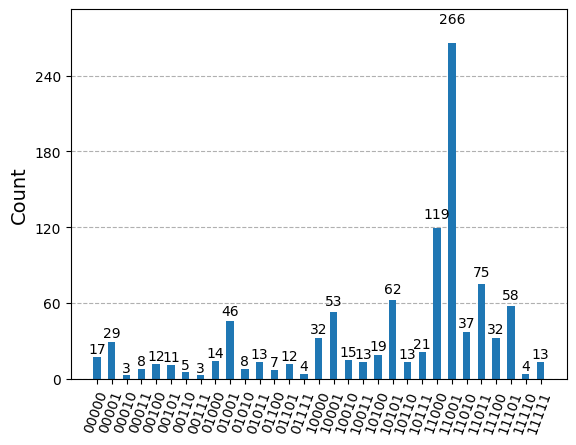

In [113]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler


# Import the fake backend from the fake provider
from qiskit_ibm_runtime.fake_provider import FakeGuadalupeV2

# Get a fake backend from the fake provider
backend = FakeGuadalupeV2()

# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuit = transpile(qc, backend)
# transpiled_circuit.draw('mpl', style="iqp")

# Run the transpiled circuit using the simulated fake backend
job = backend.run(transpiled_circuit)
counts = job.result().get_counts()
plot_histogram(counts)

In [172]:
answer = counts.most_frequent()
print( 'Most frequent measured bit string = ' , answer)
print( 'Most frequent measured integer = ' ,int(answer,2))

Most frequent measured bit string =  11001
Most frequent measured integer =  25


# Success!*

The quantum* computer got it right 1/4 of the time! Which is enough to see that it is the most likely answer!

(fake quantum computer*)

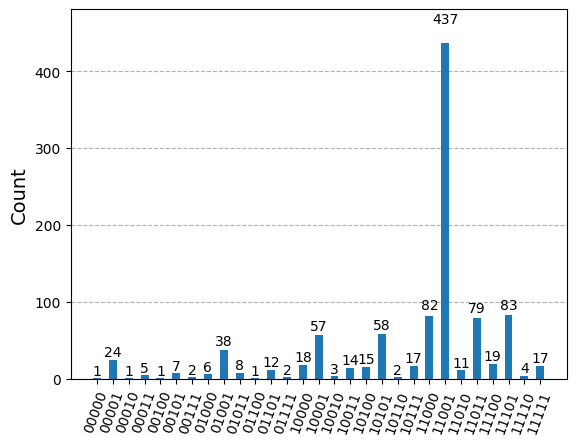

In [58]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
 
# initialize service to access real backends
service = QiskitRuntimeService()
 
# call refresh to retrieve latest backend data
# note that this overwrites your local qiskit-ibm-runtime files
backend = FakeBrisbane()
backend.refresh(service)


# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuit = transpile(qc, backend)
# transpiled_circuit.draw('mpl', style="iqp")

# Run the transpiled circuit using the simulated fake backend
job = backend.run(transpiled_circuit)
counts = job.result().get_counts()
plot_histogram(counts)

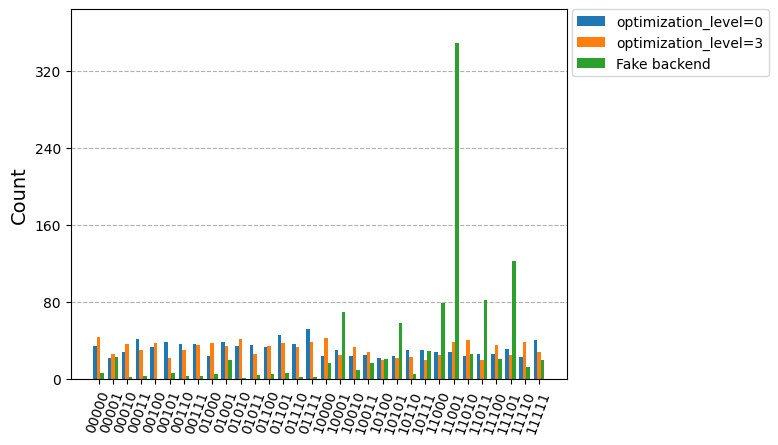

In [185]:
'''Plot results'''
plot_histogram(
    [result[0].data.bc.get_counts(),
     result[1].data.bc.get_counts(),
     counts],
    bar_labels=False,
    legend=[
        "optimization_level=0",
        "optimization_level=3",
        "Fake backend"
    ],
)

sus...

https://quantumcomputing.stackexchange.com/questions/37720/ibm-fake-backend-vs-real-backend

# Plotting 2Q error rates (echo cross resonance gate error)

Name: fake_brisbane
Version: 2
No. of qubits: 127

ECR Gate Error Rate (1, 0): 0.00646
ECR Gate Error Rate (2, 1): 0.01164
ECR Gate Error Rate (3, 2): 0.01331
ECR Gate Error Rate (4, 3): 0.00529
ECR Gate Error Rate (4, 5): 0.01045
ECR Gate Error Rate (4, 15): 0.00613
ECR Gate Error Rate (6, 5): 0.00585
ECR Gate Error Rate (6, 7): 0.00532
ECR Gate Error Rate (7, 8): 0.00715
ECR Gate Error Rate (8, 9): 0.00658
ECR Gate Error Rate (10, 9): 0.00549
ECR Gate Error Rate (10, 11): 0.00799
ECR Gate Error Rate (11, 12): 0.00499
ECR Gate Error Rate (12, 17): 0.01352
ECR Gate Error Rate (13, 12): 0.00593
ECR Gate Error Rate (14, 0): 0.00671
ECR Gate Error Rate (14, 18): 0.01691
ECR Gate Error Rate (15, 22): 0.00461
ECR Gate Error Rate (16, 8): 0.02481
ECR Gate Error Rate (16, 26): 0.0065
ECR Gate Error Rate (17, 30): 0.0705
ECR Gate Error Rate (18, 19): 0.01069
ECR Gate Error Rate (20, 19): 0.00351
ECR Gate Error Rate (20, 33): 0.02822
ECR Gate Error Rate (21, 20): 0.00733
ECR Gate Error Rate (21

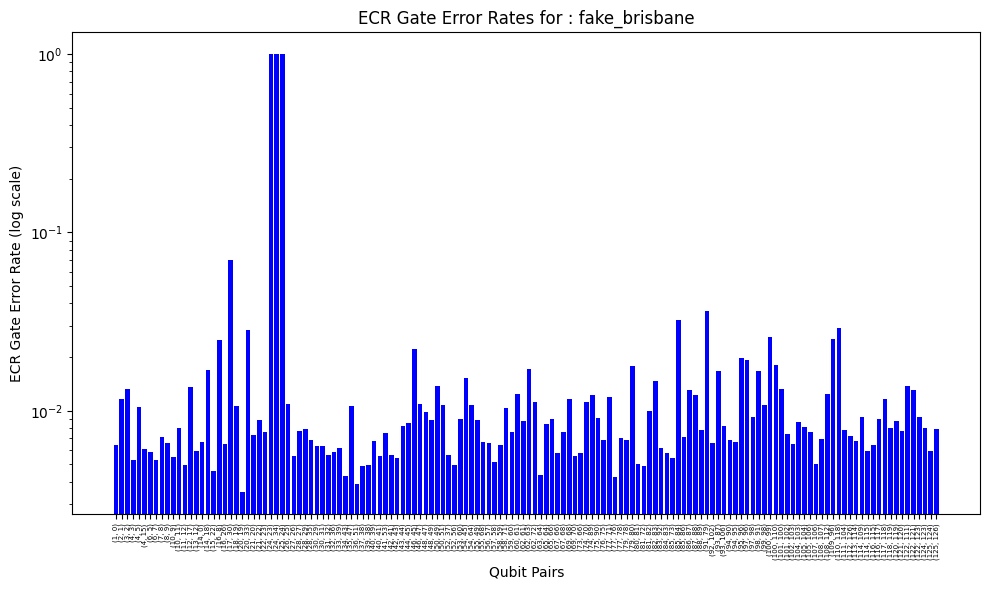

In [161]:
backend = FakeBrisbane()
backend.refresh(service)

print(f"Name: {backend.name}")
print(f"Version: {backend.version}")
print(f"No. of qubits: {backend.num_qubits}\n")

# Extract ECR gate error rates
error_rates = []
qubit_pairs = []
for qubit1 in range(backend.num_qubits):
    for qubit2 in range(backend.num_qubits):
        if qubit1 != qubit2:
            try:
                error_rate = round(backend.target["ecr"][(qubit1, qubit2)].error,5)
                error_rates.append(error_rate)
                qubit_pairs.append(f"({qubit1}, {qubit2})")
                print(f"ECR Gate Error Rate ({qubit1}, {qubit2}): {error_rate}")
            except KeyError:
                pass

# Plotting the ECR gate error rates
plt.figure(figsize=(10, 6))
plt.bar(qubit_pairs, error_rates, color='blue')
plt.yscale('log')
plt.xlabel("Qubit Pairs")
plt.ylabel("ECR Gate Error Rate (log scale)")
plt.title(f"ECR Gate Error Rates for : {backend.name}")
plt.xticks(rotation=90, fontsize=5)
plt.tight_layout()
plt.show()


Name: ibm_brisbane
Version: 2
No. of qubits: 127

ECR Gate Error Rate (1, 0): 0.0064637289447831425
ECR Gate Error Rate (2, 1): 0.011636195204956457
ECR Gate Error Rate (3, 2): 0.013313688524213885
ECR Gate Error Rate (4, 3): 0.0052921538034408355
ECR Gate Error Rate (4, 5): 0.010448240414161869
ECR Gate Error Rate (4, 15): 0.0061263208440275885
ECR Gate Error Rate (6, 5): 0.005847988919740754
ECR Gate Error Rate (6, 7): 0.005324228985708779
ECR Gate Error Rate (7, 8): 0.0071475741132180914
ECR Gate Error Rate (8, 9): 0.006580530297705944
ECR Gate Error Rate (10, 9): 0.005491283903102884
ECR Gate Error Rate (10, 11): 0.007992123614192714
ECR Gate Error Rate (11, 12): 0.004991907801244422
ECR Gate Error Rate (12, 17): 0.013517105479407154
ECR Gate Error Rate (13, 12): 0.005928456206056754
ECR Gate Error Rate (14, 0): 0.006712605419304574
ECR Gate Error Rate (14, 18): 0.016908399432306376
ECR Gate Error Rate (15, 22): 0.004608656474944073
ECR Gate Error Rate (16, 8): 0.024813260145251315

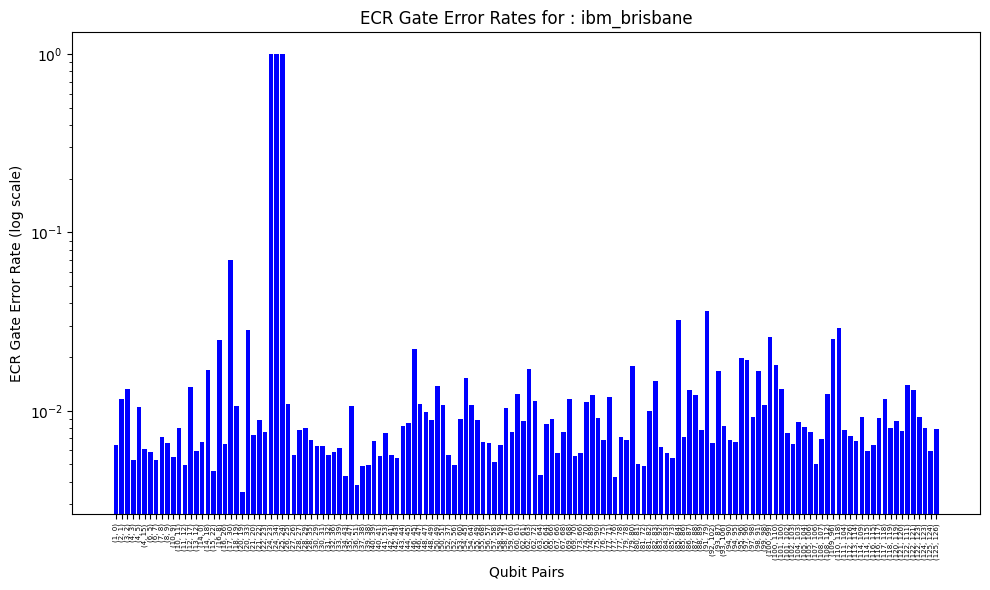

In [162]:
backend = service.backend('ibm_brisbane')
backend.refresh()

print(f"Name: {backend.name}")
print(f"Version: {backend.version}")
print(f"No. of qubits: {backend.num_qubits}\n")

# Extract ECR gate error rates
error_rates = []
qubit_pairs = []
for qubit1 in range(backend.num_qubits):
    for qubit2 in range(backend.num_qubits):
        if qubit1 != qubit2:
            try:
                error_rate = backend.target["ecr"][(qubit1, qubit2)].error
                error_rates.append(error_rate)
                qubit_pairs.append(f"({qubit1}, {qubit2})")
                print(f"ECR Gate Error Rate ({qubit1}, {qubit2}): {error_rate}")
            except KeyError:
                pass

# Plotting the ECR gate error rates
plt.figure(figsize=(10, 6))
plt.bar(qubit_pairs, error_rates, color='blue')
plt.yscale('log')
plt.xlabel("Qubit Pairs")
plt.ylabel("ECR Gate Error Rate (log scale)")
plt.title(f"ECR Gate Error Rates for : {backend.name}")
plt.xticks(rotation=90, fontsize=5)
plt.tight_layout()
plt.show()

### to be continued...

# Exercises

  1. Show that the quantum sum and carry circuit works by inputing a=1, b=1, cin=1 and showing the output.

  1. Use the qiskit method '.decompose()', to decompose a single Toffoli gate into it's bare CNOT gates and single qubit gates. How many CNOT gates are required? How many single qubit gates are required?

  1. How much error does a single Toffoli gate accumulate if it is run with CNOT gates with 1% error each and single qubit gates with 0.1% error each?

  1. How does this expand if qubits are distant on the coupling map of the quantum processor? That is, how many more CNOT gates are needed for qubits that are connected via two additional intermediate qubits? (Like qubit 1 and qubit 10 on the ibmq_guadalupe processor)?

  1. Are any entangled states created during the quantum adder circuit? Why or why not?

  1. Change the inputs a and b to larger numbers that require an extra bit so that the input register of the quantum adder expands from 4 qubits each to 5 qubits each.

  1. Run the 5 bit quantum adder using a unitary simulator ( no noise ).

  1. Run the 5 bit quantum adder using noise from a 27 qubit system from IBM by importing its noise data. Do you get the correct answer?


In [ ]:
'''
Exercise 1
'''


In [ ]:
'''
Exercise 2
'''
